In [3]:
%pylab inline

import pandas as pd
import pandas_datareader.data as web
import scipy.stats as stat

rcParams['figure.figsize'] = (12,8)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [8]:
px = web.get_data_yahoo('^GSPC','2004-11-27','2019-11-27').Close
vix = web.get_data_yahoo('^VIX','2004-11-27','2019-11-27').Close

In [10]:
logR = np.log(px/px.shift(1))

In [68]:
stocks = web.get_data_yahoo(['AAPL','BAC','GOOG','GOOGL','MSFT','PG','JNJ'],'2014-11-27','2019-11-27').Close

In [110]:
stocks_realized = np.sqrt((np.log(stocks/stocks.shift(1))**2).rolling(252).sum()).iloc[252:]
index_strikes = vix.shift(252).iloc[252:]
spx_leg = ((logR**2).rolling(252).sum() - (index_strikes/100)**2) * 100*(500e3/(2*index_strikes/100))

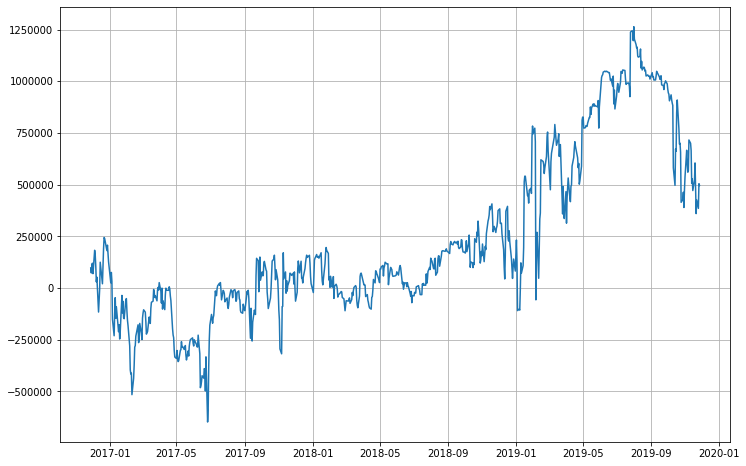

In [137]:
premium = 0.08
stocks_strikes = index_strikes[stocks_realized.index]/100 + premium
stk_leg = (stocks_realized**2).subtract(stocks_strikes**2,axis=0).mean(axis=1) * 100*(500e3/(2*stocks_strikes))

plot(stk_leg - spx_leg)

In [138]:
def varswap(R,K,I,t,vega):
    var_units = 100 * vega / (2 * K)
    return var_units*((R**2 - K**2)*t + (I**2 - K**2)*(1-t))

In [226]:
t_start = np.arange(len(logR)//23+1)*23+1

In [243]:
values = pd.Series(0,index=logR.index)
for i in range(len(t_start)-1):
    period = logR.iloc[t_start[i]-1:t_start[i+1]]
    K = vix.loc[period.index[0]]/100
    realized = (period**2).cumsum().iloc[1:]
    t = np.arange(1,len(realized)+1)/len(realized)
    realized_ann = realized*252/(t*len(realized))
    values[realized.index] = varswap(realized_ann,K,vix.loc[realized.index]/100,t,50e3)

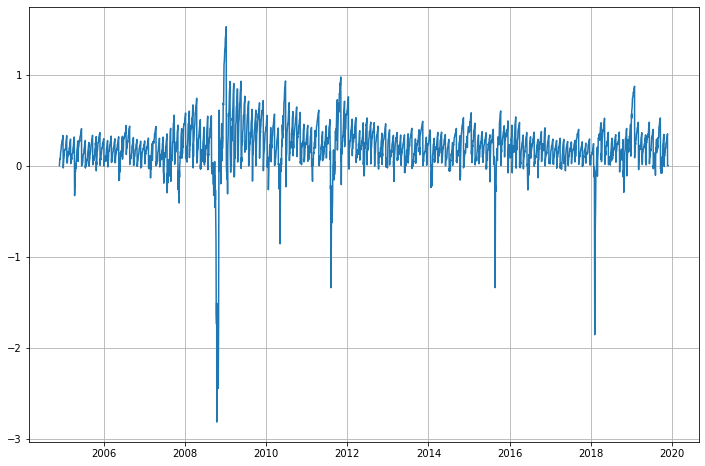

In [244]:
plot(-values/1e6)

In [65]:
N = 23
realized = np.sqrt((logR**2).rolling(N).sum()*252/N).iloc[N:]
strikes = vix.shift(N).iloc[N:]
payoffs = varswap_payoff(realized,strikes/100,-50e3)

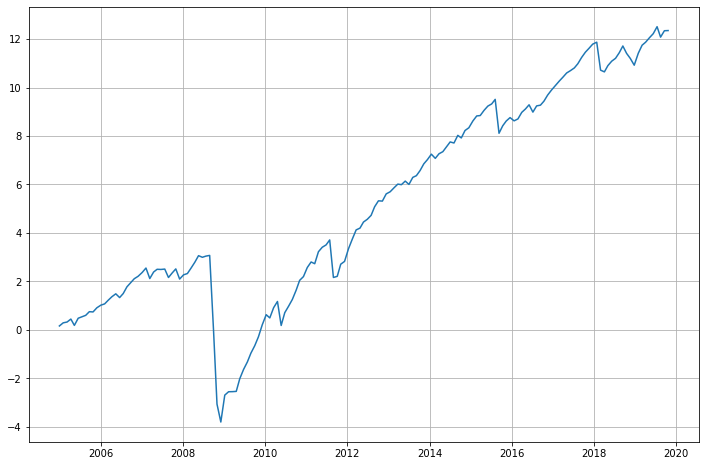

In [62]:
plot(payoffs[np.arange(len(payoffs) // N)*N].cumsum()/1e6)

In [254]:
subseq_realized = np.sqrt((logR**2).rolling(23).sum()*252/23).shift(-23)
implied = vix/100
premium = subseq_realized - implied

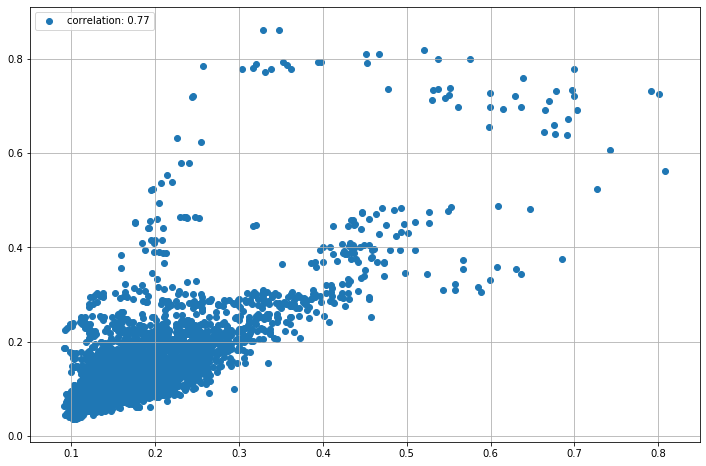

In [257]:
scatter(implied,subseq_realized,label='correlation: %0.2f'%implied.corr(subseq_realized))
legend(loc='upper left')

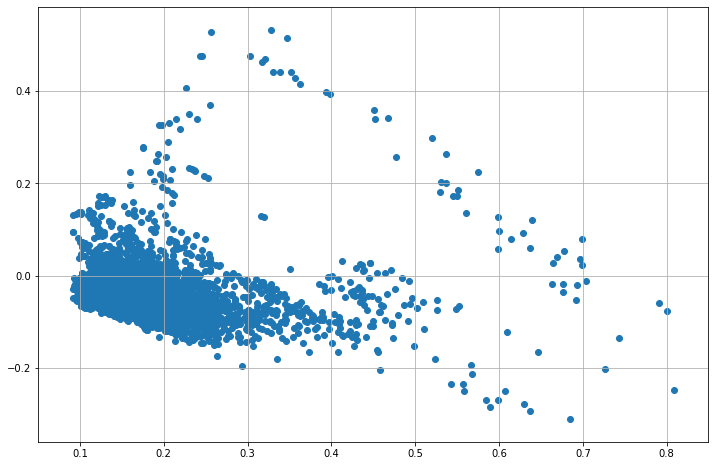

In [258]:
scatter(implied, premium)

0.052900951288201714